# The Film Junky Union

## 1-Project Description

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to reach an F1 score of at least 0.85.

## 2-Initialization

Imports in Jupyter notebooks allow users to access external libraries for extended functionality and facilitate code organization by declaring dependencies at the beginning of the notebook, ensuring clear and efficient development.

In [1]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier 
from nltk.corpus import stopwords
from tqdm.auto import tqdm

1. **re**: is a Python library that provides tools for working with regular expressions, allowing for advanced string searching, pattern matching, and manipulation.

2. **tqdm**: is a Python library that provides customizable progress bars to monitor loops, data loading, and other iterative processes.

3. **NumPy**: is a Python library for numerical computing that provides support for arrays, matrices, and high-level mathematical functions.

4. **Matplotlib**: is a Python library for creating static, interactive, and animated visualizations, offering a flexible environment for plotting data.

5. **Seaborn**: is a Python library built on Matplotlib that simplifies the creation of statistical visualizations, offering tools for drawing attractive and informative graphics.

6. **Pandas**: is a Python library for data manipulation and analysis, providing data structures like DataFrames for managing labeled data.

7. **scikit-learn**: is a Python library for machine learning that includes algorithms for classification, regression, clustering, and model evaluation tools.

8. **NLTK**: is a Python library for natural language processing that offers tools for text processing, tokenization, stemming, classification, and more linguistic tasks.

9. **spaCy**: is a Python library for natural language processing, offering pre-trained models for parsing, tokenization, named entity recognition, and more.

10. **LightGBM**: is a Python library for efficient gradient boosting, designed for high-performance training of large-scale datasets in machine learning tasks.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

try:
    plt.style.use('seaborn')
except OSError:
    try:
        plt.style.use('seaborn-v0_8')
    except OSError:
        pass

tqdm.pandas()

The first line, `%matplotlib inline`, is a magic command in Jupyter notebooks that ensures any plots generated by `matplotlib` are displayed directly within the notebook itself. The second line, `%config InlineBackend.figure_format = 'png'`, sets the figure format for inline plots to PNG, which is commonly used for its balance between quality and size. The third line, `%config InlineBackend.figure_format = 'retina'`, adjusts the plot resolution to be higher (retina display quality), improving visual clarity on high-DPI screens.

The `try-except` block that follows attempts to apply the `seaborn` plotting style to `matplotlib`. The first `plt.style.use('seaborn')` line tries to use the standard seaborn style. If an `OSError` occurs (likely because seaborn is not available or not installed), it will attempt to use an alternative `seaborn-v0_8` style. If both attempts fail, it simply passes without applying any style.

Finally, `tqdm.pandas()` integrates the `tqdm` progress bar into `pandas` operations, allowing you to see a progress bar when using methods like `apply()`, `map()`, or `applymap()` on DataFrames or Series.

In [3]:
def load_csv():
    local_path = './datasets/imdb_reviews.tsv'
    server_path = '/datasets/imdb_reviews.tsv'
    
    try:
        return pd.read_csv(local_path, sep='\t')
    except:
        return pd.read_csv(server_path, sep='\t')

The `load_csv()` function attempts to load a tab-separated `.tsv` file of IMDb reviews. It first tries to read the file from a local path (`'./datasets/imdb_reviews.tsv'`). If that fails, it catches the error and tries loading the file from a server path (`'/datasets/imdb_reviews.tsv'`). Both attempts use `pd.read_csv()` with a tab delimiter.

In [4]:
df = load_csv()
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


The key fields are:

- **review**: The text of the review.
- **pos**: The sentiment label, where '0' represents negative and '1' represents positive.
- **ds_part**: Indicates whether the dataset is for training ('train') or testing ('test').

## 3-Preparation

Next, the data will be processed and prepared for the task assigned by The Film Junky Union.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

All data types appear to be appropriate, which will ensure proper data handling and analysis.

In [6]:
def check_df(df):
    missing_values = df.isna()
    duplicates = df.duplicated()
    print(f'There are {missing_values.sum().sum()} missing values and {duplicates.sum()} duplicate rows.')

    double_check = df[['review', 'pos', 'ds_part']].duplicated()
    print(f'Found {double_check.sum()} duplicate rows that may require review.')

The `check_df()` function checks a DataFrame (`df`) for missing values and duplicates. It first calculates missing values with `df.isna()`, then checks for duplicates with `df.duplicated()`. It prints a summary of the total missing values and duplicate rows found.

Next, it performs a targeted check for duplicates in specific columns: `review`, `pos`, and `ds_part`. Any duplicates found in these columns are flagged as possibly requiring additional review, and the count is printed.

In [7]:
check_df(df)

There are 4 missing values and 0 duplicate rows.
Found 90 duplicate rows that may require review.


The dataset contains four missing values and no exact duplicate rows. However, 90 rows appear to be near-duplicates and need to be addressed.

In [8]:
df = df.dropna()
df = df.drop_duplicates(subset=['review', 'pos', 'ds_part'])
check_df(df)

There are 0 missing values and 0 duplicate rows.
Found 0 duplicate rows that may require review.


This cleans the DataFrame `df` by first dropping any rows with missing values using `dropna()`. It then removes duplicate rows based on the `review`, `pos`, and `ds_part` columns with `drop_duplicates()`, keeping only the first instance of each unique combination. Each operation directly updates `df` with the cleaned data.

Now, the dataset contains no missing values, no duplicate rows, and no near-duplicates requiring review.

## 4-Analysis

With the data processed, it can now be analyzed to gain insights and set expectations for the model's performance.

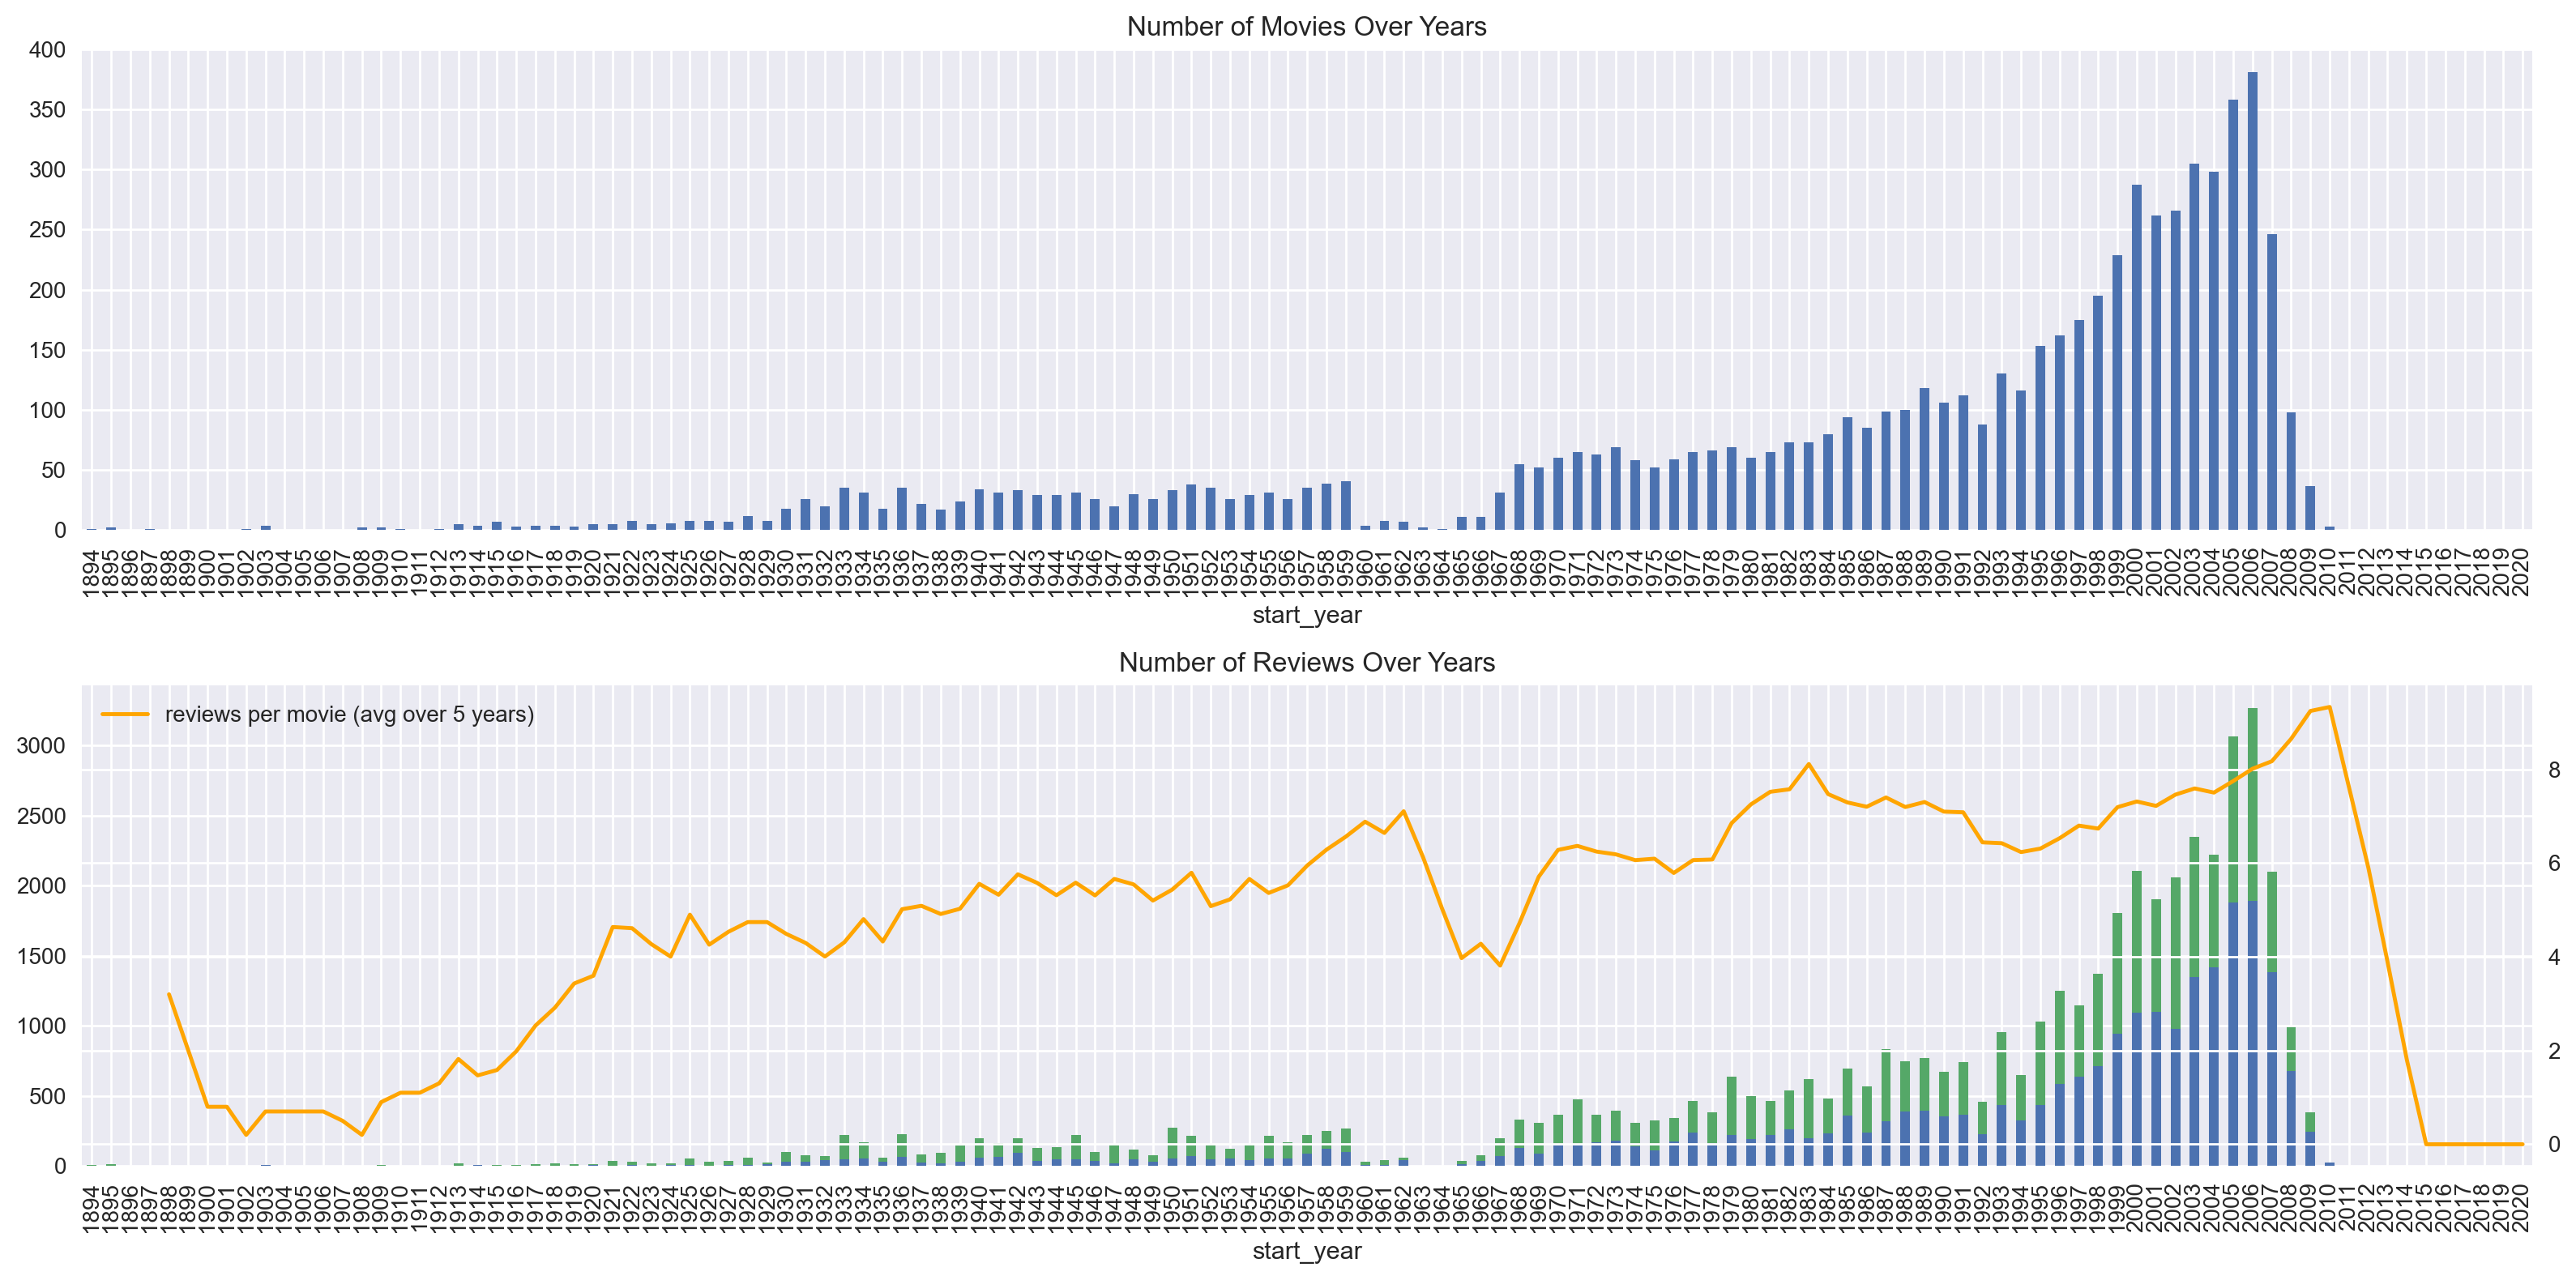

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The **top chart** shows a steady rise in movie releases from the late 1980s, peaking in the 2000s, and then declining post-2010.

The **bottom chart** combines a bar plot of annual review counts with an orange line for the average reviews per movie over 5 years. Both reviews and average reviews per movie increase until the 2000s, followed by a drop after 2010.

These charts suggest an upward trend in both movie production and review volume, particularly from the 1980s to the early 2000s, followed by a decline.

c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


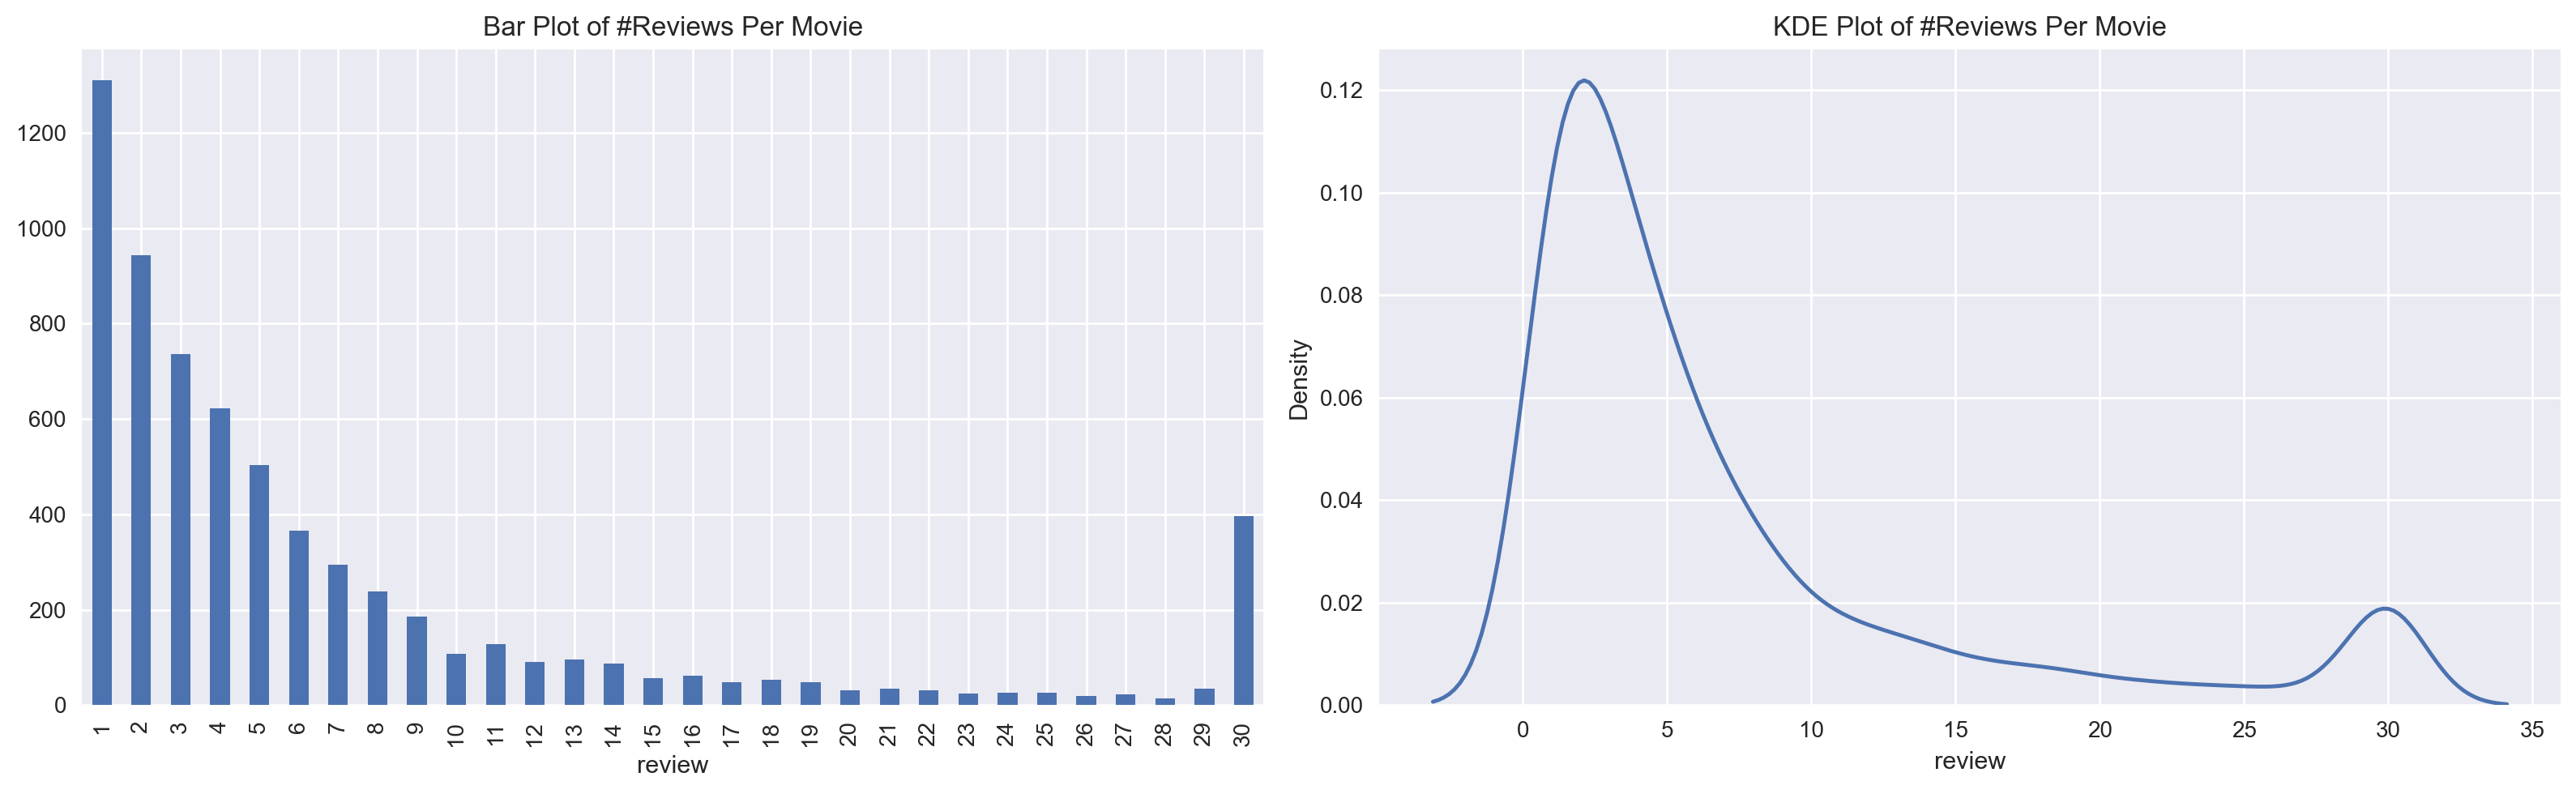

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Bar Plot**: Shows most movies have only a few reviews, peaking at one review, with a small spike at 30, indicating a possible review cap.
  
**KDE Plot**: Highlights a high density of movies with 1-2 reviews, tapering off as reviews increase, with a minor bump near 30 reviews.

These plots indicate that most movies receive few reviews, with a small subset having many.
Together, these plots suggest that the majority of movies have very few reviews, with a small subset having significantly more.

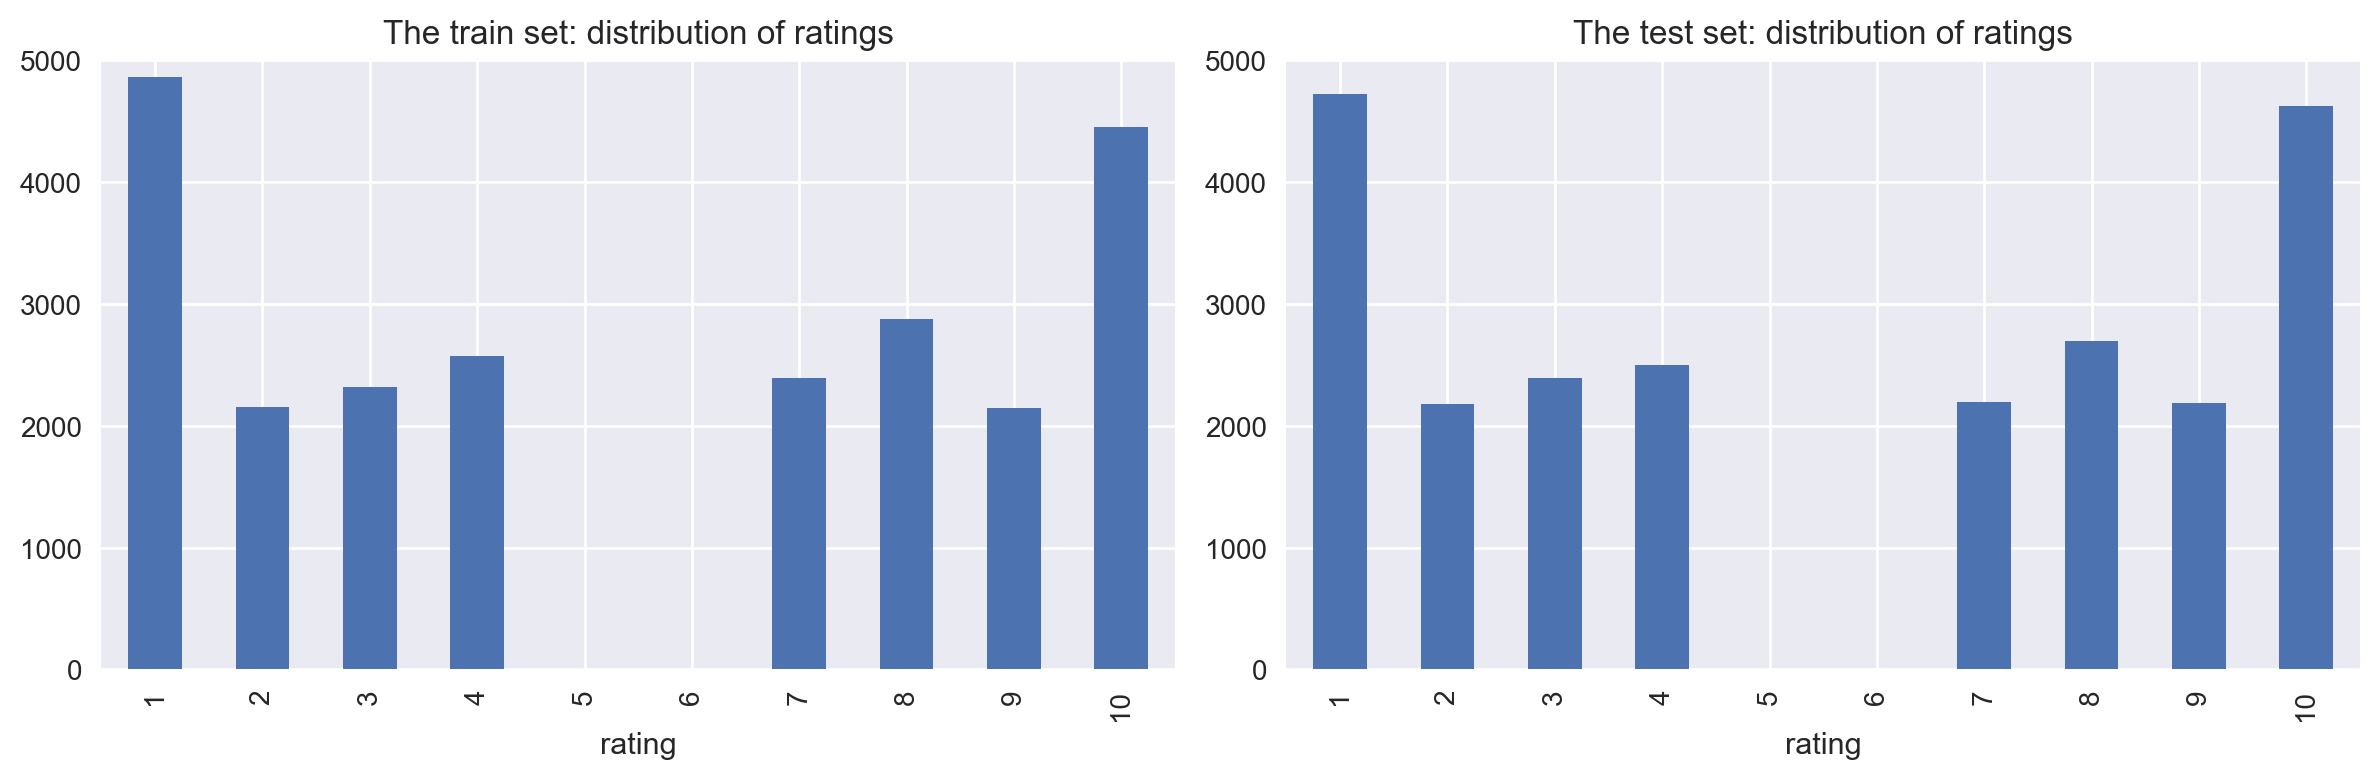

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

**Training Set (Left)**: Ratings are distributed from 1 to 10, with peaks at the extreme ratings of 1 and 10, indicating a higher frequency of polarized ratings. Mid-range ratings are less frequent, with moderate counts around ratings 4 to 8.

**Test Set (Right)**: The distribution is similar to the training set, showing high frequencies at ratings 1 and 10, suggesting that users tend to rate movies either very low or very high, with fewer moderate ratings in between.

Both charts suggest a similar rating pattern across the datasets, with a preference for extreme ratings.

C:\Users\acoyg\AppData\Local\Temp\ipykernel_8872\967270254.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\acoyg\AppData\Local\Temp\ipykernel_8872\967270254.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remo

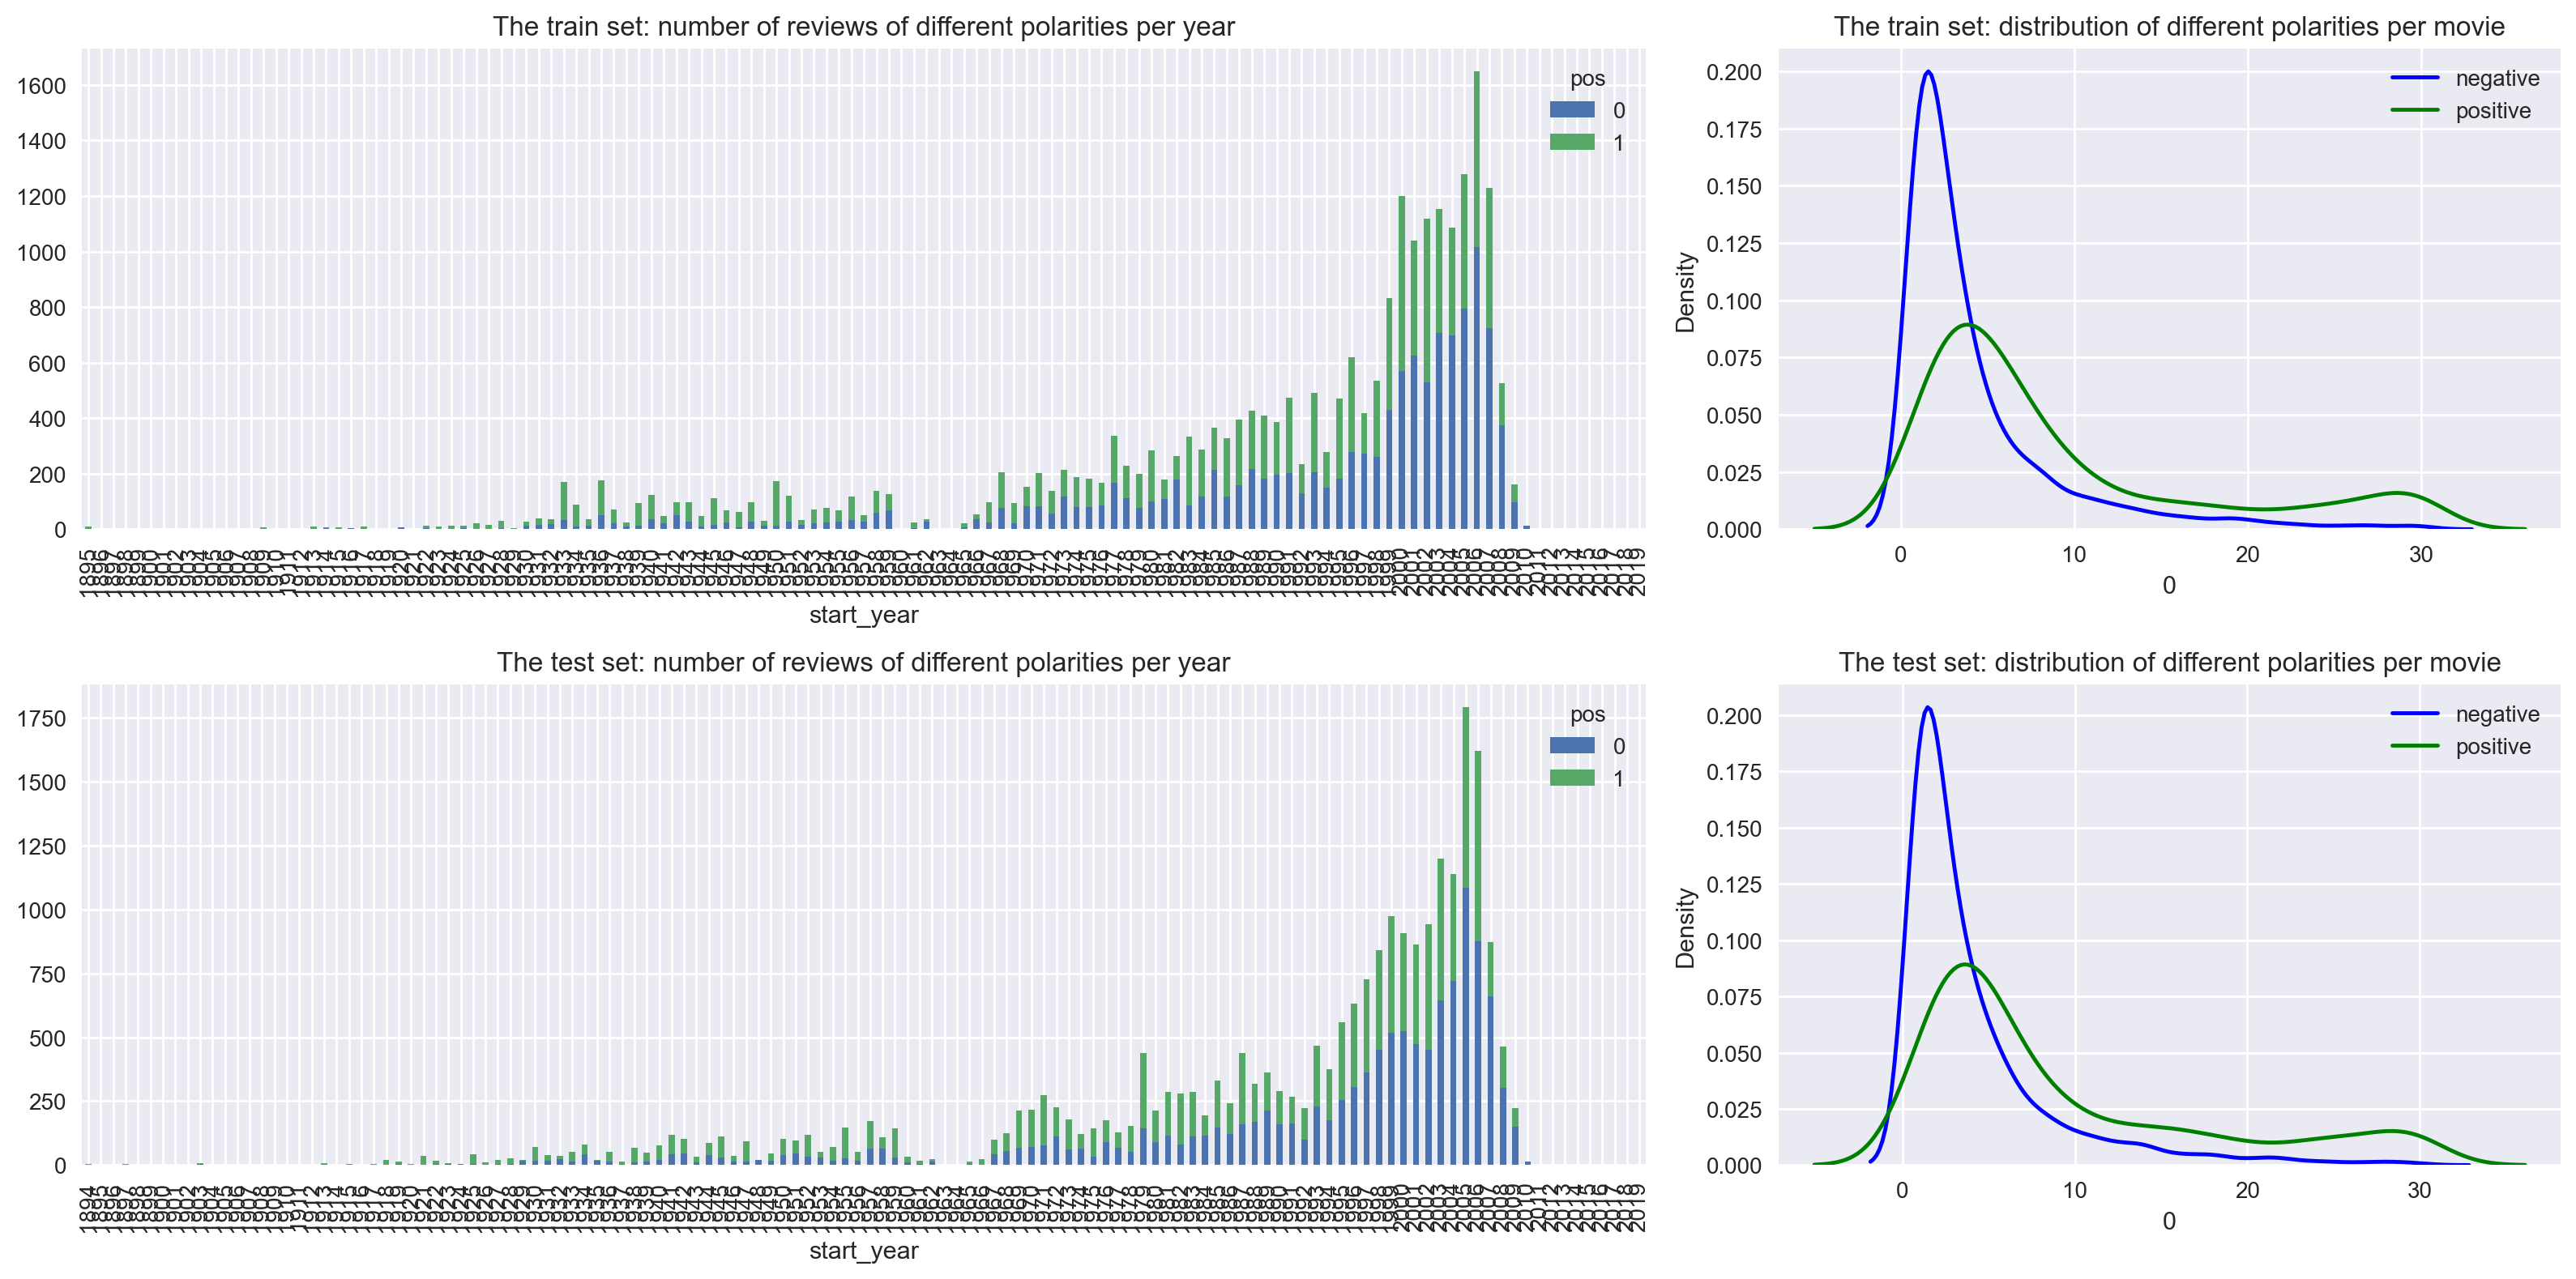

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Bar Charts (Left)**: The top-left chart shows the yearly count of positive (green) and negative (blue) reviews in the training set, while the bottom-left chart shows the same for the test set. Both datasets show an increase in reviews over time, particularly from the late 1980s onward, with a peak in recent years. Positive reviews generally outnumber negative ones.

**Density Plots (Right)**: The top-right density plot shows the distribution of positive and negative reviews per movie in the training set, and the bottom-right plot shows the same for the test set. Both sets reveal a higher density of movies with few negative reviews compared to positive ones, with the peak for negative reviews (blue) being more pronounced.

These plots highlight similar trends in both datasets, with an increase in reviews over time and a higher concentration of movies with more negative reviews than positive ones.

## 5-Training and Model Evaluation 

### 5.1-Set-up

In [13]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

The `evaluate_model` function assesses a machine learning model on training and test datasets, calculating key metrics and creating visualizations. It initializes `eval_stats` to store metrics and sets up three subplots for F1, ROC, and PRC curves. For each dataset, it makes predictions, calculates probabilities, and computes F1 scores across thresholds, along with ROC AUC and Average Precision Score (APS), saving these values in `eval_stats`. The function then plots F1 scores, ROC, and PRC curves, marking specific thresholds for clarity. It also calculates accuracy and F1 score at the default threshold (0.5) and prints a summary DataFrame of rounded metrics for both datasets. This function provides a detailed model evaluation with metrics and visual insights.

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[\W\d]+', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acoyg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This defines a `normalize_text` function to preprocess text by removing non-essential components for cleaner analysis. First, it loads a set of English stopwords using NLTK’s `stopwords` package, filtering out common, unimportant words. In `normalize_text`, the text is converted to lowercase to standardize capitalization. Then, it removes any non-word characters and digits with a regular expression, leaving only alphabetic content. The text is split into individual tokens (words), and any word found in `stop_words` is removed. Finally, the tokens are rejoined into a single cleaned string. This process helps make the text more consistent and relevant for tasks like natural language processing.

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocess(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

This uses the `spacy` library for text preprocessing, specifically to lemmatize words, which reduces them to their base forms. The `nlp` object is created by loading the small English language model `en_core_web_sm` from `spaCy`, with the parser and named entity recognition (`ner`) components disabled to streamline processing.

The `text_preprocess` function takes a string, `text`, and processes it with the `nlp` pipeline. It then returns a string where each word has been lemmatized, joining the lemmatized tokens with spaces. This approach helps standardize text by removing variations of words, making it more consistent for further NLP tasks.

In [16]:
df['review_norm'] = df['review'].apply(normalize_text)

This applies the `normalize_text` function to each entry in the `review` column of the DataFrame `df` and stores the results in a new column called `review_norm`.

### 5.2-Train / Test Split

In [17]:
df_reviews_train = df.query('ds_part == "train"').copy()
df_reviews_test = df.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

This splits the DataFrame `df` into training and testing sets based on a column called `ds_part`, which has a value of either `train` or `test`. It uses `query` to filter rows accordingly and creates copies named `df_reviews_train` and `df_reviews_test`. The `train_target` and `test_target` variables are then set to the `pos` column in the training and testing DataFrames, respectively. Similarly, `train_features` and `test_features` are assigned the `review_norm` column from each DataFrame, containing the preprocessed text data. This separates the feature and target sets for model training and evaluation.

### 5.3-Evaluating Models

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


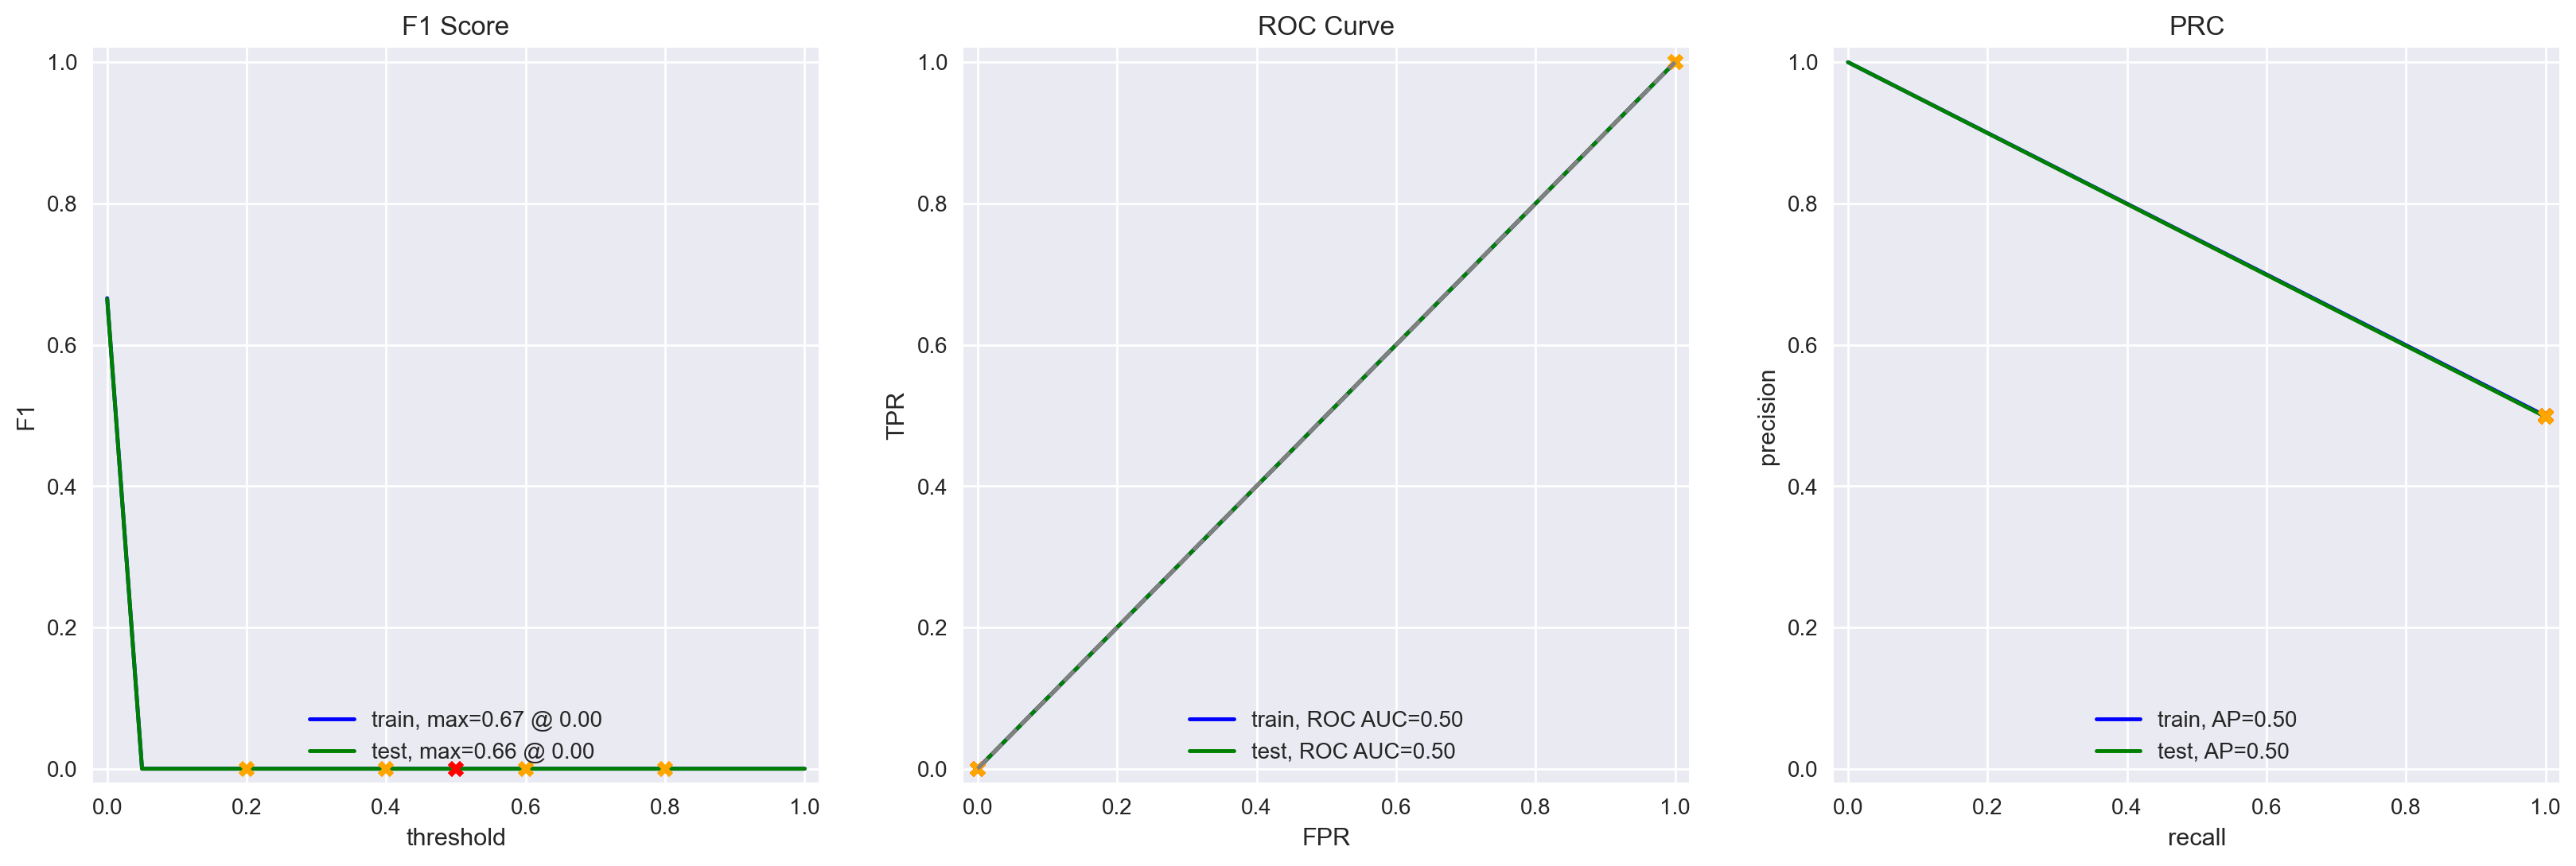

In [18]:
dy_model = DummyClassifier(strategy='most_frequent')
dy_model.fit(train_features, train_target)
evaluate_model(dy_model, train_features, train_target, test_features, test_target)

The `DummyClassifier` uses basic strategies like random guessing or predicting the most common class. This classifier serves as a baseline, yielding metrics typical of random predictions: 0.5 for accuracy, APS, and ROC AUC, with an F1 score of 0.0.

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


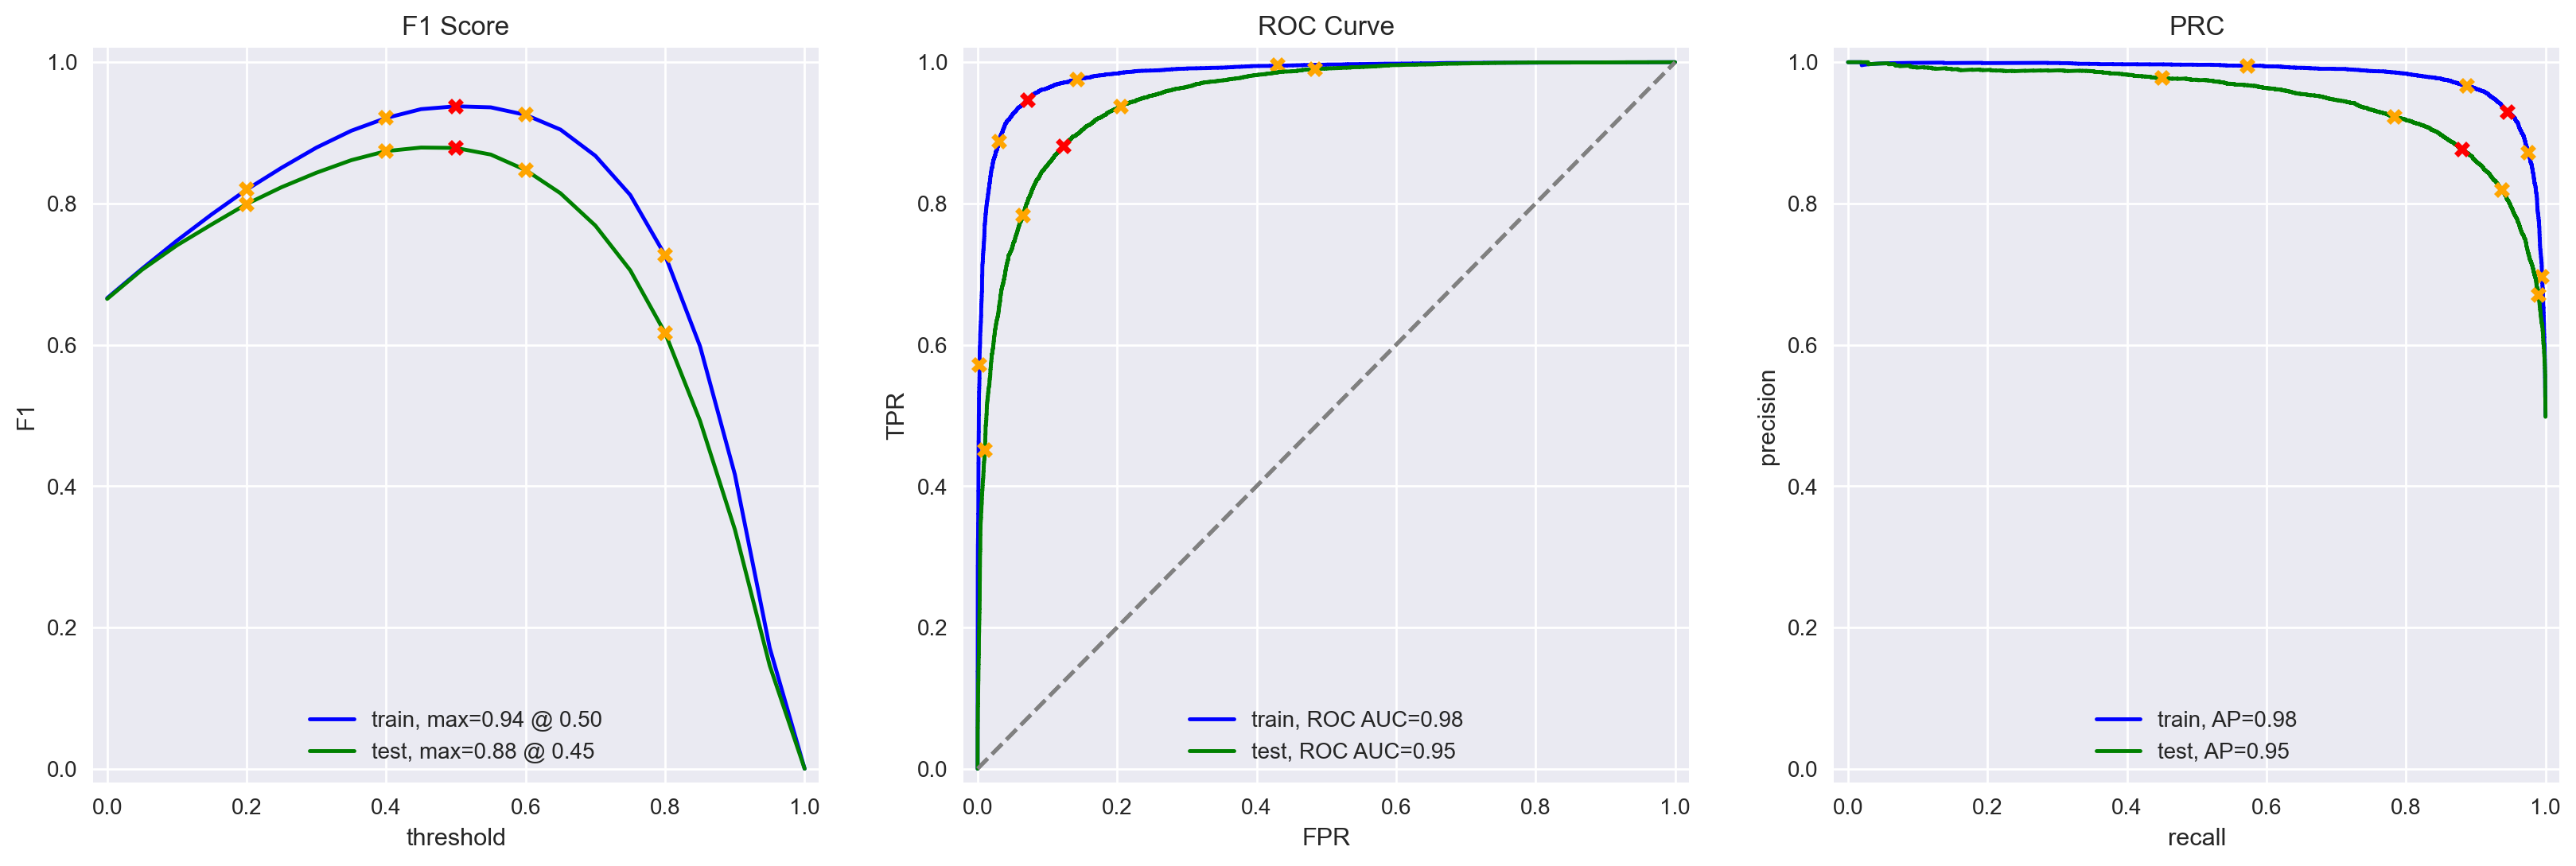

In [19]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(train_features)
train_features_tfidf = tfidf.transform(train_features)
test_features_tfidf = tfidf.transform(test_features)

lr_model = LogisticRegression()
lr_model.fit(train_features_tfidf, train_target)
evaluate_model(lr_model, train_features_tfidf, train_target, test_features_tfidf, test_target)

These metrics show a significant improvement over the baseline, demonstrating that the logistic regression model trained with TF-IDF features effectively captures patterns in the data.

- **Accuracy**: 0.94 on training and 0.88 on testing, indicating high classification performance.
- **F1 Score**: Similarly, 0.94 on training and 0.88 on testing, showing good balance between precision and recall.
- **APS**: 0.98 for training and 0.95 for testing, reflecting strong model reliability in detecting positive cases.
- **ROC AUC**: 0.98 for training and 0.95 for testing, suggesting excellent class discrimination.

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.94


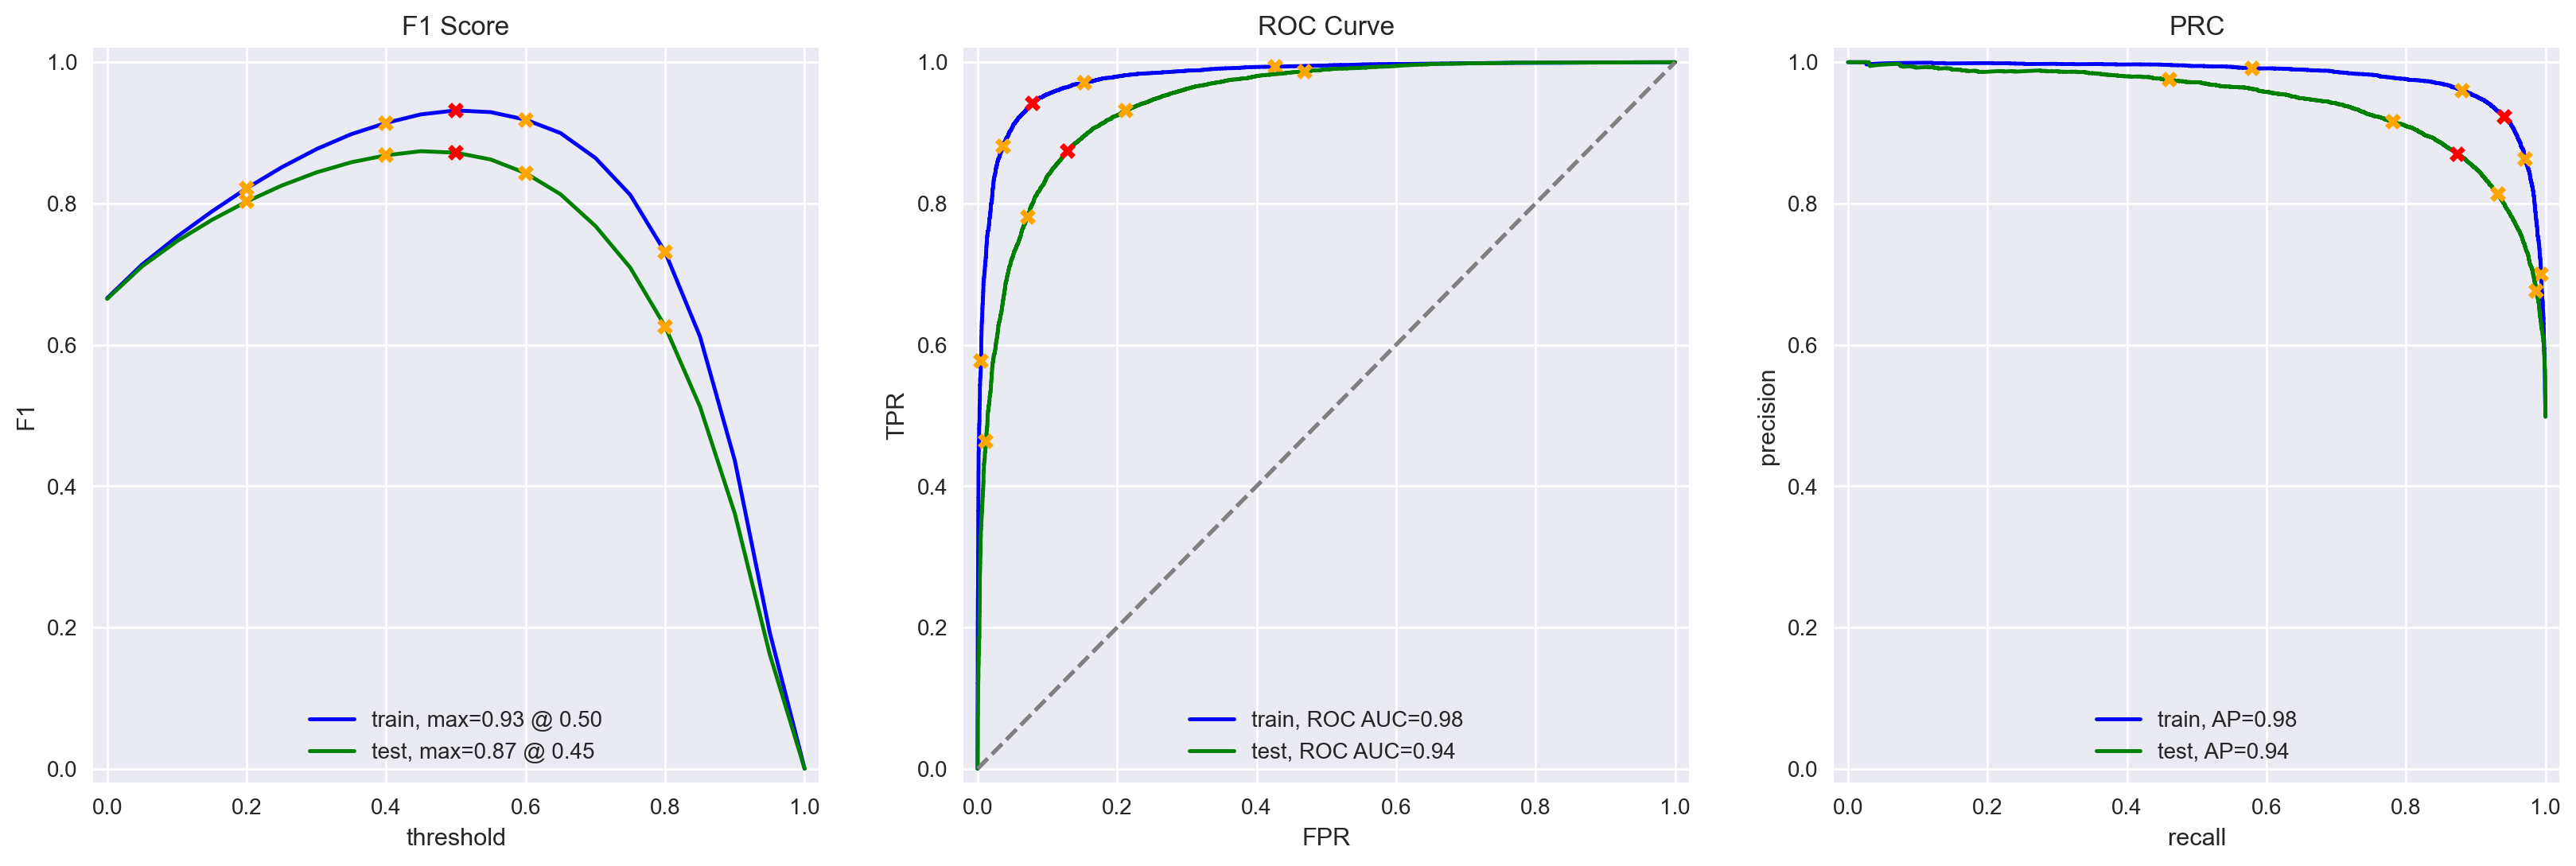

In [20]:
processed_train = train_features.apply(text_preprocess)
processed_test = test_features.apply(text_preprocess)

tfidf2 = TfidfVectorizer(stop_words='english')
tfidf2.fit(processed_train)
train_features_tfidf = tfidf2.transform(processed_train)
test_features_tfidf = tfidf2.transform(processed_test)

lr_model2 = LogisticRegression()
lr_model2.fit(train_features_tfidf, train_target)
evaluate_model(lr_model2, train_features_tfidf, train_target, test_features_tfidf, test_target)

These metrics indicate that lemmatization with TF-IDF features supports robust performance, closely aligning with previous results. As can be seen in the graph and comparing the data, there is minimal difference, suggesting potential improvements in generalization across various word forms.

- **Accuracy**: 0.93 on training and 0.87 on testing, indicating high performance.
- **F1 Score**: 0.93 on training and 0.87 on testing, showing good balance.
- **APS**: 0.98 for training and 0.94 for testing, reflecting reliability in detecting positive cases.
- **ROC AUC**: 0.98 for training and 0.94 for testing, indicating strong class discrimination.

[LightGBM] [Info] Number of positive: 11863, number of negative: 11895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423330
[LightGBM] [Info] Number of data points in the train set: 23758, number of used features: 9189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499327 -> initscore=-0.002694
[LightGBM] [Info] Start training from score -0.002694
          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


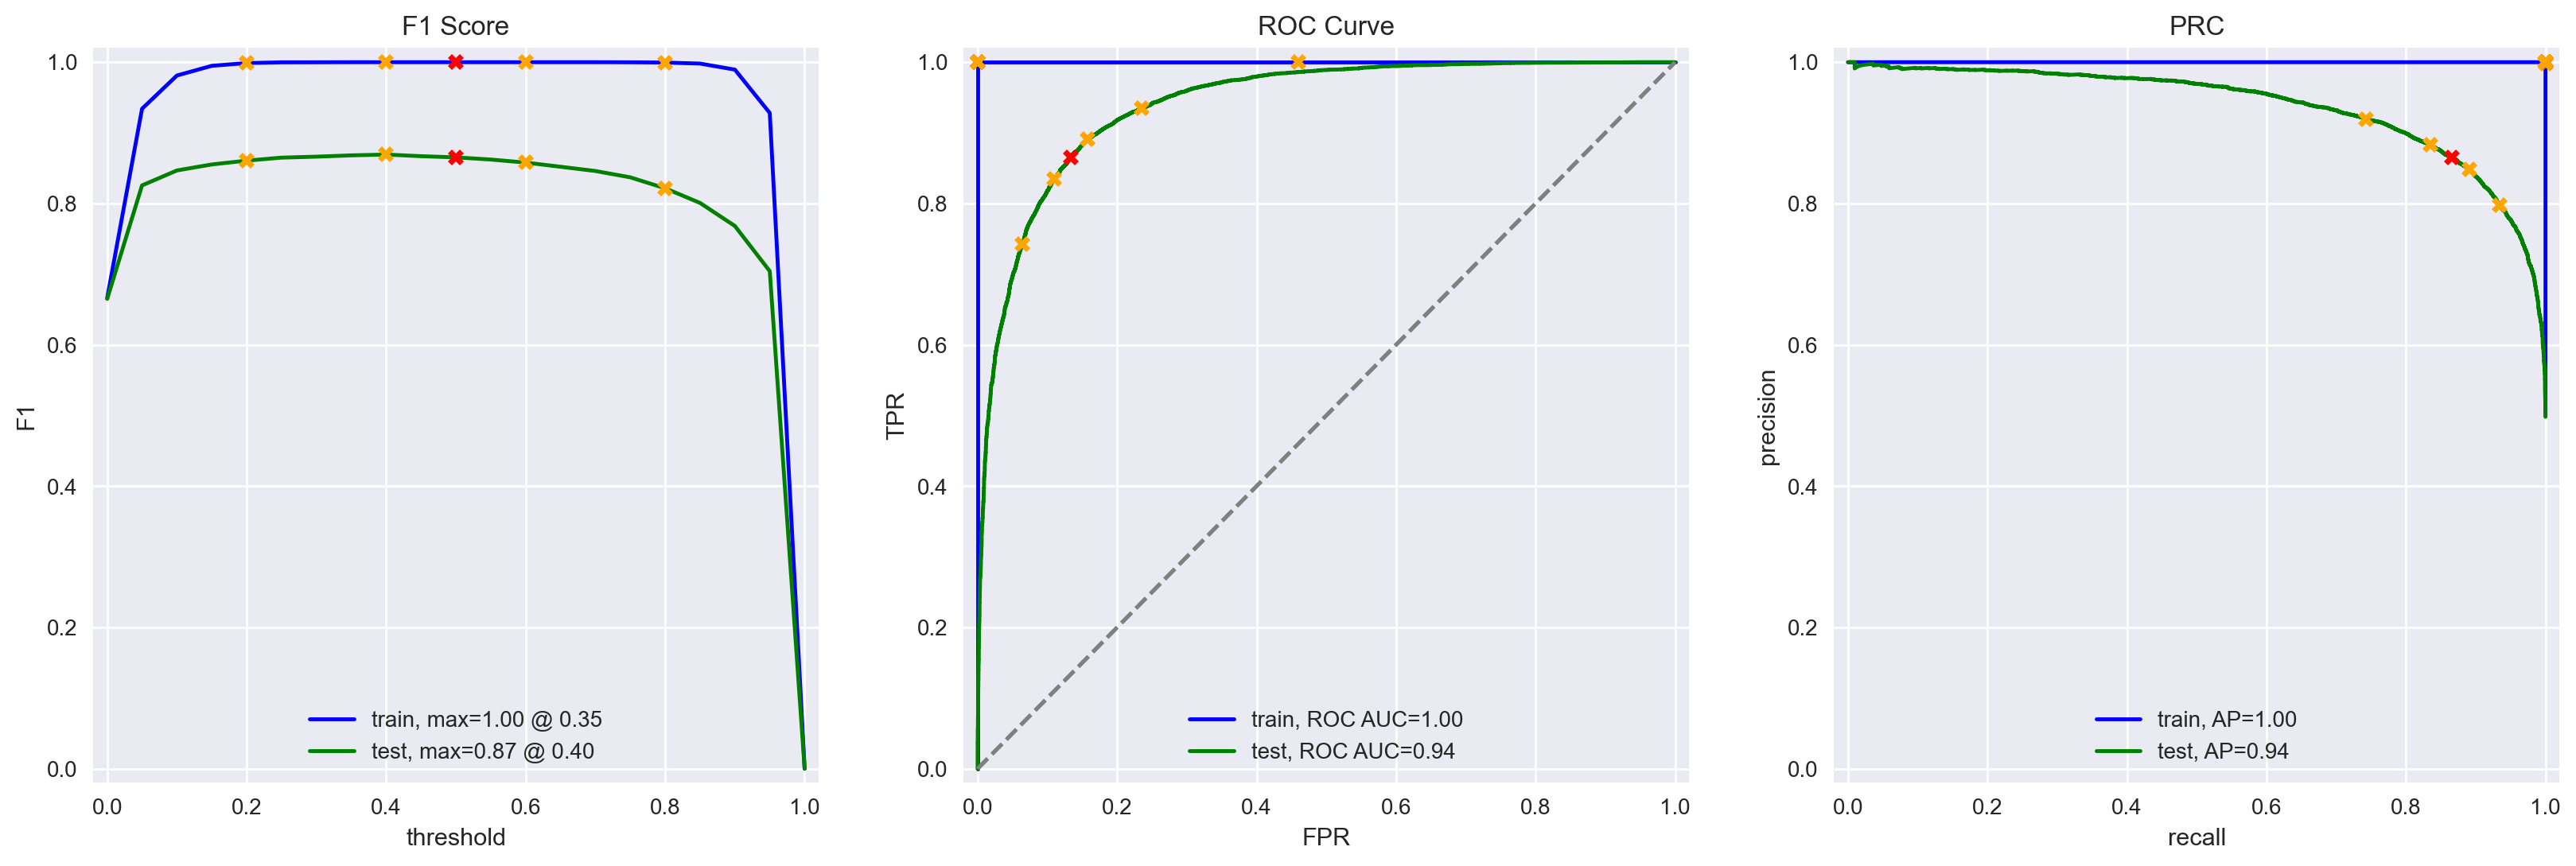

In [21]:
lgbm = LGBMClassifier(n_estimators=1000)
lgbm.fit(train_features_tfidf, train_target)
evaluate_model(lgbm, train_features_tfidf, train_target, test_features_tfidf, test_target)

The perfect training scores suggest that the `LGBMClassifier` may be overfitting, achieving flawless performance on training data but slightly lower generalization on the test set. This indicates that the model is highly effective; however, a consistent trend across all training sets shows that the score remains unchanged from one model to another.

- **Accuracy**: 1.0 on training, indicating perfect accuracy on the training set, and 0.87 on testing, showing strong but not flawless performance.
- **F1 Score**: 1.0 on training and 0.87 on testing, suggesting an effective balance between precision and recall.
- **APS**: 1.0 for training and 0.94 for testing, indicating reliable detection of positive cases.
- **ROC AUC**: 1.0 on training and 0.94 on testing, showing excellent class discrimination.

## 6-My Reviews

### 6.1-Set Up

Due to the similarity in test scores, I find it essential to further evaluate the models using real user reviews. I’ll be sourcing reviews from Amazon for a movie I’m eager to watch called *Monkey Man*.

In [22]:
my_reviews = pd.DataFrame([
    "This was a very emotional movie to watch. He did SUCH a good job writing it and directing it. The fight scenes kept my son watching and the premise kept me watching. 5 stars. Hope to see more of his work.",
    "This easily belongs in the top 3 best movies of the year. Dev Patel was an unknown to me before I watched this. I SEE YOU DEV.",
    "Very well done - a part 2 would be welcome.",
    "Parts were well written and then they got lazy. It was a good watch tho.",
    "The trailer looked amazing. Doesn’t live up to it, sadly.",
    "Very disappointed. Monkey man doesn't even train that hard or that long (barely a month) and all of a sudden he is Superman.",
    "The writing was awful, the fight scenes were laughable and don't get me started with the acting.",
    "Thought it was a super b rated John Wick. Not much action. Somehow went from knowing no fighting style to mastering everything. Very bad movie compared to what its trailer made it out to be."
], columns=['review'])

my_texts = my_reviews['review'].apply(normalize_text)
my_texts

0    emotional movie watch good job writing directi...
1    easily belongs top best movies year dev patel ...
2                         well done part would welcome
3           parts well written got lazy good watch tho
4                    trailer looked amazing live sadly
5    disappointed monkey man even train hard long b...
6    writing awful fight scenes laughable get start...
7    thought super b rated john wick much action so...
Name: review, dtype: object

This creates a DataFrame `my_reviews` containing several movie reviews. Each review is stored in the `review` column. It then applies the `normalize_text` function to the `review` column. The result is stored in `my_texts`, which is a Series of cleaned and standardized reviews, ready for further analysis or model prediction. 

The rows are arranged in descending order, with every two rows representing a decrease in star rating, following the sequence: 5, 4, 2, 1.

In [23]:
def text_eval(model_predict):
    for i, review in enumerate(my_texts.str.slice(0, 100)):
        print(f'{model_predict[i]:.2f}:  {review}')

This function helps visualize the model’s prediction (e.g., probability of a positive sentiment) alongside a snippet of the original text, making it easier to interpret the model's output.

### 6.2-Evaluation

In [24]:
my_reviews_pred_lr1 = lr_model.predict_proba(tfidf.transform(my_texts))[:, 1]
text_eval(my_reviews_pred_lr1)

0.50:  emotional movie watch good job writing directing fight scenes kept son watching premise kept watchin
0.74:  easily belongs top best movies year dev patel unknown watched see dev
0.60:  well done part would welcome
0.65:  parts well written got lazy good watch tho
0.61:  trailer looked amazing live sadly
0.18:  disappointed monkey man even train hard long barely month sudden superman
0.01:  writing awful fight scenes laughable get started acting
0.46:  thought super b rated john wick much action somehow went knowing fighting style mastering everything


For the `lr_model`, here are the rephrased sentiment analysis results in order:

- **Row 1**: Positive sentiment, with a score of 0.50, reflecting a neutral to slightly positive sentiment. This score does not strongly align with a clear positive sentiment.
- **Row 2**: Positive sentiment, with a score of 0.74, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 3**: Positive sentiment, with a score of 0.60, reflecting a moderately positive sentiment. This score aligns reasonably with the sentiment.
- **Row 4**: Positive sentiment, with a score of 0.65, indicating a somewhat positive sentiment. This score aligns with the sentiment.
- **Row 5**: Negative sentiment, with a score of 0.61, reflecting a moderately positive sentiment. This score does not align with the sentiment.
- **Row 6**: Negative sentiment, with a score of 0.18, indicating a likely negative sentiment. This score aligns correctly with the sentiment.
- **Row 7**: Negative sentiment, with a score of 0.01, indicating a strongly negative sentiment. This score aligns correctly with the sentiment.
- **Row 8**: Negative sentiment, with a score of 0.46, reflecting a neutral to slightly negative sentiment. This score does not strongly align with a clear negative sentiment.

In [25]:
my_reviews_pred_lr2 = lr_model2.predict_proba(tfidf2.transform(my_texts.apply(lambda x: text_preprocess(x))))[:, 1]
text_eval(my_reviews_pred_lr2)

0.58:  emotional movie watch good job writing directing fight scenes kept son watching premise kept watchin
0.72:  easily belongs top best movies year dev patel unknown watched see dev
0.62:  well done part would welcome
0.46:  parts well written got lazy good watch tho
0.69:  trailer looked amazing live sadly
0.28:  disappointed monkey man even train hard long barely month sudden superman
0.00:  writing awful fight scenes laughable get started acting
0.51:  thought super b rated john wick much action somehow went knowing fighting style mastering everything


For the `lr_model2`, here are the rephrased sentiment analysis results in order:

- **Row 1:** Positive sentiment, with a score of 0.58, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 2:** Positive sentiment, with a score of 0.72, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 3:** Positive sentiment, with a score of 0.62, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 4:** Positive sentiment, with a score of 0.46, reflecting a likely negative sentiment. This score does not align with the sentiment.
- **Row 5:** Negative sentiment, with a score of 0.69, indicating a likely positive sentiment. This score does not align with the sentiment.
- **Row 6:** Negative sentiment, with a score of 0.28, indicating a likely negative sentiment. This score aligns correctly with the sentiment.
- **Row 7:** Negative sentiment, with a score of 0.00, indicating a likely negative sentiment. This score aligns correctly with the sentiment.
- **Row 8:** Negative sentiment, with a score of 0.51, reflecting a likely positive sentiment. This score does not align with the sentiment.

Note: In this model, row 1 is now more positive instead of neutral, row 4 incorrectly became negative, row 5 inaccurately appears more positive, and row 8 now incorrectly leans positive.

In [26]:
my_reviews_pred_lgbm = lgbm.predict_proba(tfidf2.transform(my_texts))[:, 1]
text_eval(my_reviews_pred_lgbm)

0.58:  emotional movie watch good job writing directing fight scenes kept son watching premise kept watchin
0.79:  easily belongs top best movies year dev patel unknown watched see dev
0.68:  well done part would welcome
0.79:  parts well written got lazy good watch tho
0.96:  trailer looked amazing live sadly
0.09:  disappointed monkey man even train hard long barely month sudden superman
0.00:  writing awful fight scenes laughable get started acting
0.06:  thought super b rated john wick much action somehow went knowing fighting style mastering everything


For the `lgbm`, here are the rephrased sentiment analysis results in order:

- **Row 1:** Positive sentiment, with a score of 0.58, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 2:** Positive sentiment, with a score of 0.79, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 3:** Positive sentiment, with a score of 0.68, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 4:** Positive sentiment, with a score of 0.79, indicating a likely positive sentiment. This score aligns correctly with the sentiment.
- **Row 5:** Negative sentiment, with a score of 0.96, indicating a likely positive sentiment. This score does not align with the sentiment.
- **Row 6:** Negative sentiment, with a score of 0.09, indicating a likely negative sentiment. This score aligns correctly with the sentiment.
- **Row 7:** Negative sentiment, with a score of 0.00, indicating a likely negative sentiment. This score aligns correctly with the sentiment.
- **Row 8:** Negative sentiment, with a score of 0.06, indicating a likely negative sentiment. This score aligns correctly with the sentiment.

Note: This model appears to perform the best overall, with the exception of row 5, which all models seem to struggle with—understandably so. This issue could potentially be resolved by incorporating a "bag-of-words" approach, ensuring that stop words like "doesn't" are included rather than excluded. This is essential because it preserves the original context, distinguishing phrases like "trailer looked amazing live sadly" from "The trailer looked amazing. Doesn’t live up to it, sadly," which convey very different sentiments.

## 7 Conclusion:

- The LGBM classifier appears to perform best for this scenario.
- Text normalization using `en_core_web_sm` from `spaCy` made no significant difference in model performance.
- Personal testing of the model could effectively showcase its true potential in real-world applications.